# 🦴 MURA — Musculoskeletal Radiograph Classification
## Multi-Class: Body Part + Abnormality Detection (14 Classes)

> **Dataset:** MURA v1.1 — Stanford ML Group  
> **Model:** DenseNet169 — Transfer Learning + Fine-Tuning  
> **Task:** Classify X-Ray into one of 14 classes (7 body parts × Normal/Abnormal)  
> **Metric:** Accuracy · AUC · Cohen Kappa · F1

---
| Class | Label |
|-------|-------|
| ELBOW_Normal | 0 | ELBOW_Abnormal | 1 |
| FINGER_Normal | 2 | FINGER_Abnormal | 3 |
| FOREARM_Normal | 4 | FOREARM_Abnormal | 5 |
| HAND_Normal | 6 | HAND_Abnormal | 7 |
| HUMERUS_Normal | 8 | HUMERUS_Abnormal | 9 |
| SHOULDER_Normal | 10 | SHOULDER_Abnormal | 11 |
| WRIST_Normal | 12 | WRIST_Abnormal | 13 |

## 📚 Block 1 — Imports & Configuration

In [4]:
import os, glob, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.applications import DenseNet169
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    cohen_kappa_score, accuracy_score,
    precision_score, recall_score, f1_score
)
import gc

warnings.filterwarnings('ignore')

# ── Reproducibility ──────────────────────────────────────
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ── Config ───────────────────────────────────────────────
IM_SIZE     = 320
BATCH_SIZE  = 32
NUM_CLASSES = 14
BASE_PATH   = '/kaggle/input/datasets/cjinny/mura-v11/MURA-v1.1'
OUT_PATH    = '/kaggle/working'

# ── Class Mapping ────────────────────────────────────────
BODY_PARTS = ['ELBOW','FINGER','FOREARM','HAND','HUMERUS','SHOULDER','WRIST']
CLASS_NAMES = []
for bp in BODY_PARTS:
    CLASS_NAMES.append(f'{bp}_Normal')
    CLASS_NAMES.append(f'{bp}_Abnormal')
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}

print(f'✅ TensorFlow  : {tf.__version__}')
print(f'✅ GPU         : {tf.config.list_physical_devices("GPU")}')
print(f'✅ Image Size  : {IM_SIZE}×{IM_SIZE}')
print(f'✅ Classes     : {NUM_CLASSES}')
print()
print('📋 Class Mapping:')
for name, idx in CLASS_TO_IDX.items():
    print(f'   [{idx:>2}] {name}')

✅ TensorFlow  : 2.19.0
✅ GPU         : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Image Size  : 320×320
✅ Classes     : 14

📋 Class Mapping:
   [ 0] ELBOW_Normal
   [ 1] ELBOW_Abnormal
   [ 2] FINGER_Normal
   [ 3] FINGER_Abnormal
   [ 4] FOREARM_Normal
   [ 5] FOREARM_Abnormal
   [ 6] HAND_Normal
   [ 7] HAND_Abnormal
   [ 8] HUMERUS_Normal
   [ 9] HUMERUS_Abnormal
   [10] SHOULDER_Normal
   [11] SHOULDER_Abnormal
   [12] WRIST_Normal
   [13] WRIST_Abnormal


## 📂 Block 2 — Load Data & Build DataFrames

In [5]:
def get_body_part(path):
    for p in path.split('/'):
        if p.startswith('XR_'):
            return p.replace('XR_', '')
    return None

def get_binary_label(path):
    if 'positive' in path: return 'Abnormal'
    if 'negative' in path: return 'Normal'
    return None

def build_dataframe(split='train'):
    paths = glob.glob(f'{BASE_PATH}/{split}/**/*.png', recursive=True)
    records = []
    for p in paths:
        bp = get_body_part(p)
        bl = get_binary_label(p)
        if bp and bl:
            class_name = f'{bp}_{bl}'
            if class_name in CLASS_TO_IDX:
                records.append({
                    'image_path' : p,
                    'body_part'  : bp,
                    'binary'     : bl,
                    'class_name' : class_name,
                    'label'      : CLASS_TO_IDX[class_name]
                })
    df = pd.DataFrame(records).reset_index(drop=True)
    return df

train_full = build_dataframe('train')
test_df    = build_dataframe('valid')

print(f'📊 Train : {len(train_full):,} images')
print(f'📊 Test  : {len(test_df):,}  images')
print(f'\n🏷️  Class Distribution (Train):')
print(train_full['class_name'].value_counts().to_string())

📊 Train : 36,808 images
📊 Test  : 3,197  images

🏷️  Class Distribution (Train):
class_name
WRIST_Normal         5765
SHOULDER_Normal      4211
SHOULDER_Abnormal    4168
HAND_Normal          4059
WRIST_Abnormal       3987
FINGER_Normal        3138
ELBOW_Normal         2925
ELBOW_Abnormal       2006
FINGER_Abnormal      1968
HAND_Abnormal        1484
FOREARM_Normal       1164
HUMERUS_Normal        673
FOREARM_Abnormal      661
HUMERUS_Abnormal      599


## 🔍 Block 3 — Exploratory Data Analysis

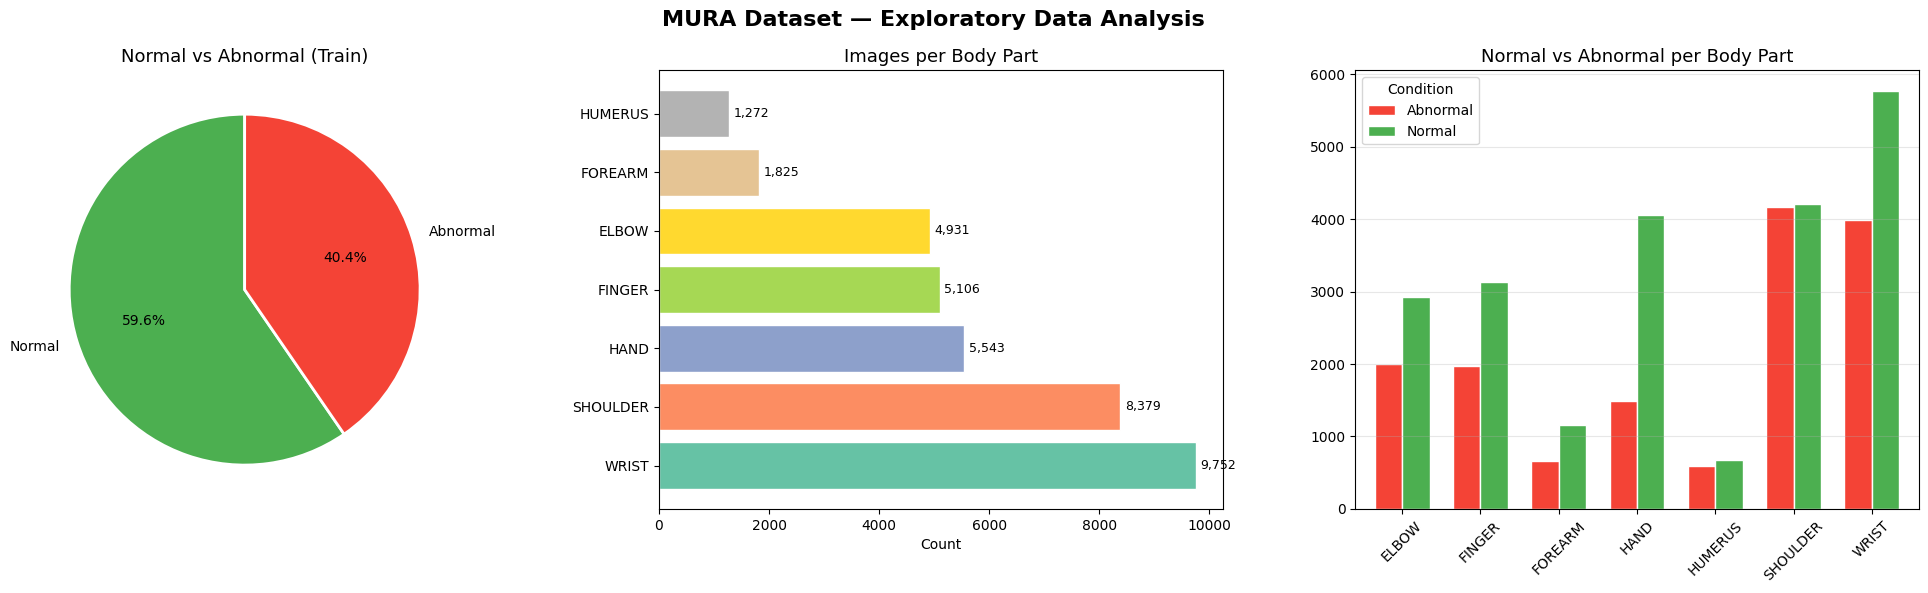

✅ EDA saved


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('MURA Dataset — Exploratory Data Analysis', fontsize=16, fontweight='bold')

# ── Plot 1: Binary distribution ──
binary_counts = train_full['binary'].value_counts()
axes[0].pie(
    binary_counts.values,
    labels=binary_counts.index,
    autopct='%1.1f%%',
    colors=['#4CAF50','#F44336'],
    startangle=90,
    wedgeprops={'edgecolor':'white','linewidth':2}
)
axes[0].set_title('Normal vs Abnormal (Train)', fontsize=13)

# ── Plot 2: Body part distribution ──
bp_counts = train_full['body_part'].value_counts()
colors_bp = plt.cm.Set2(np.linspace(0, 1, len(bp_counts)))
bars = axes[1].barh(bp_counts.index, bp_counts.values, color=colors_bp, edgecolor='white')
axes[1].set_title('Images per Body Part', fontsize=13)
axes[1].set_xlabel('Count')
for bar, val in zip(bars, bp_counts.values):
    axes[1].text(bar.get_width()+80, bar.get_y()+bar.get_height()/2,
                 f'{val:,}', va='center', fontsize=9)

# ── Plot 3: Normal vs Abnormal per body part ──
bp_pivot = train_full.groupby(['body_part','binary']).size().unstack(fill_value=0)
bp_pivot.plot(kind='bar', ax=axes[2], color=['#F44336','#4CAF50'], edgecolor='white', width=0.7)
axes[2].set_title('Normal vs Abnormal per Body Part', fontsize=13)
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title='Condition')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{OUT_PATH}/eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ EDA saved')

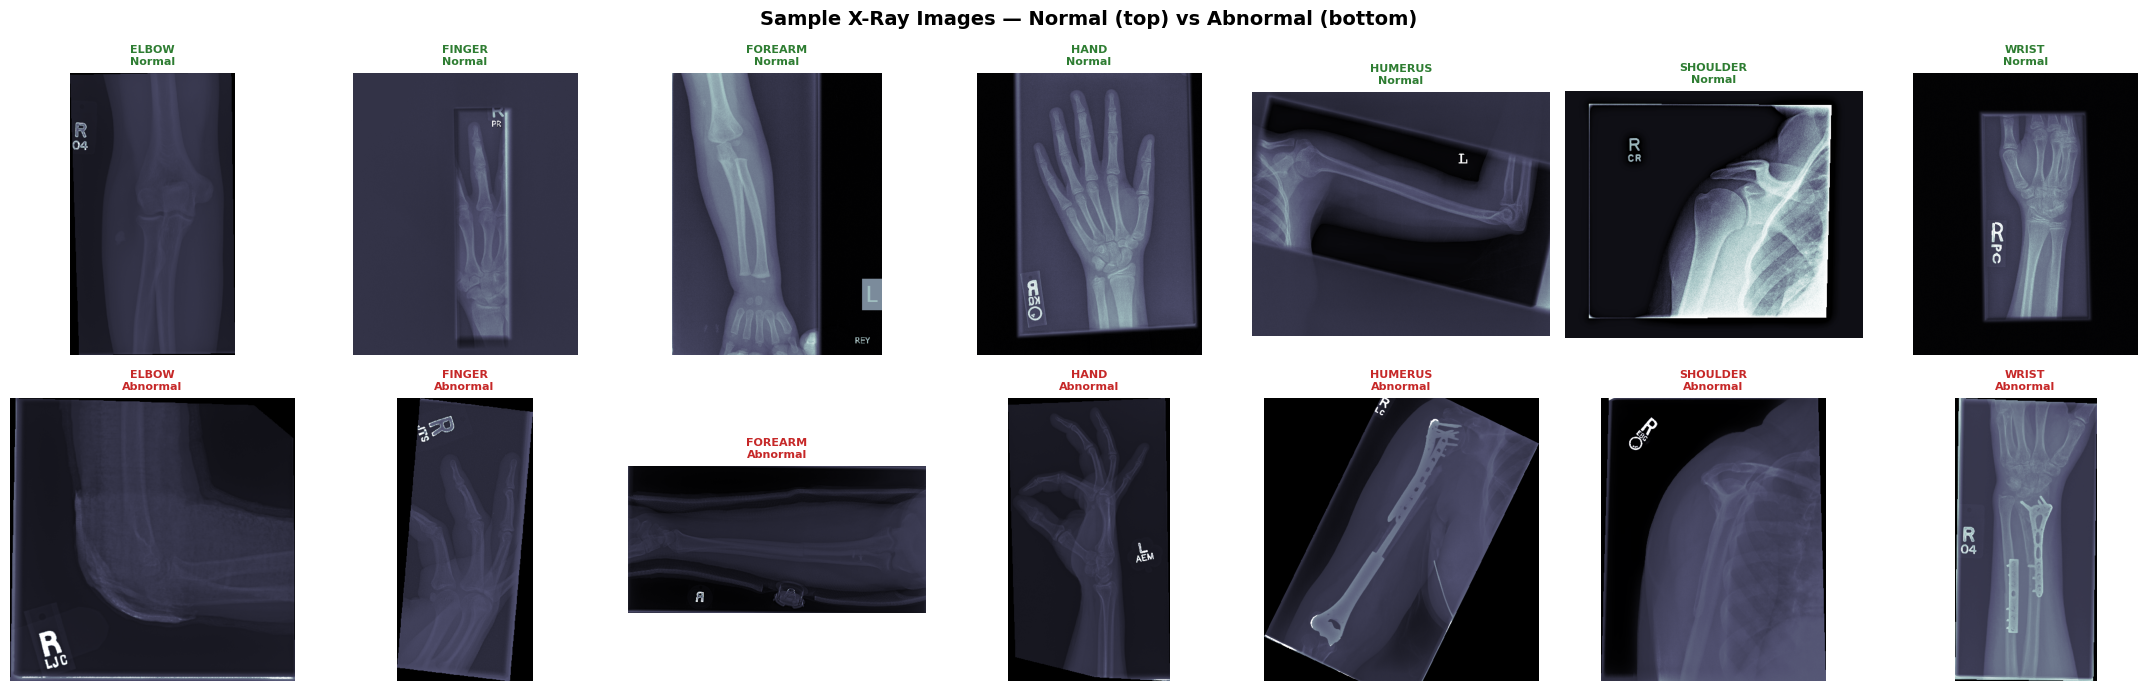

In [7]:
# ── Sample images from each body part ──
fig, axes = plt.subplots(2, 7, figsize=(22, 7))
fig.suptitle('Sample X-Ray Images — Normal (top) vs Abnormal (bottom)', fontsize=14, fontweight='bold')

for col, bp in enumerate(BODY_PARTS):
    for row, cond in enumerate(['Normal', 'Abnormal']):
        subset = train_full[(train_full['body_part']==bp) & (train_full['binary']==cond)]
        if len(subset) == 0:
            axes[row,col].axis('off'); continue
        img_path = subset.sample(1, random_state=SEED)['image_path'].values[0]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        color = '#2E7D32' if cond=='Normal' else '#C62828'
        axes[row,col].imshow(img, cmap='bone')
        axes[row,col].set_title(f'{bp}\n{cond}', fontsize=8, color=color, fontweight='bold')
        axes[row,col].axis('off')

plt.tight_layout()
plt.savefig(f'{OUT_PATH}/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## ✂️ Block 4 — Train / Validation Split + Class Weights

In [8]:
train_df, valid_df = train_test_split(
    train_full,
    test_size=0.15,
    random_state=SEED,
    stratify=train_full['label']       # stratify على الـ 14 class
)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

# ── Class Weights ──
y_train = train_df['label'].values
class_w = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_train)
CLASS_WEIGHT = {i: class_w[i] for i in range(NUM_CLASSES)}

print(f'📊 Train  : {len(train_df):,}')
print(f'📊 Valid  : {len(valid_df):,}')
print(f'📊 Test   : {len(test_df):,}')
print(f'\n⚖️  Class Weights (min={min(class_w):.3f}, max={max(class_w):.3f}):')
for i, (name, w) in enumerate(zip(CLASS_NAMES, class_w)):
    print(f'   [{i:>2}] {name:<22} → {w:.3f}')

📊 Train  : 31,286
📊 Valid  : 5,522
📊 Test   : 3,197

⚖️  Class Weights (min=0.456, max=4.390):
   [ 0] ELBOW_Normal           → 0.899
   [ 1] ELBOW_Abnormal         → 1.311
   [ 2] FINGER_Normal          → 0.838
   [ 3] FINGER_Abnormal        → 1.336
   [ 4] FOREARM_Normal         → 2.257
   [ 5] FOREARM_Abnormal       → 3.976
   [ 6] HAND_Normal            → 0.648
   [ 7] HAND_Abnormal          → 1.772
   [ 8] HUMERUS_Normal         → 3.907
   [ 9] HUMERUS_Abnormal       → 4.390
   [10] SHOULDER_Normal        → 0.624
   [11] SHOULDER_Abnormal      → 0.631
   [12] WRIST_Normal           → 0.456
   [13] WRIST_Abnormal         → 0.659


## 🔄 Block 5 — tf.data Pipeline (320×320 + Augmentation)

In [9]:
def load_and_preprocess(path, label, augment=False):
    # Load
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IM_SIZE, IM_SIZE])
    img = tf.cast(img, tf.float32) / 255.0

    # Augmentation (train only)
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.15)
        img = tf.image.random_contrast(img, 0.85, 1.15)
        img = tf.image.random_saturation(img, 0.85, 1.15)
        img = tf.image.resize_with_crop_or_pad(img, IM_SIZE+20, IM_SIZE+20)
        img = tf.image.random_crop(img, [IM_SIZE, IM_SIZE, 3])
        img = tf.clip_by_value(img, 0.0, 1.0)

    # One-hot encode label for multi-class
    label_oh = tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES)
    return img, label_oh

def make_dataset(df, augment=False, shuffle=False, batch_size=BATCH_SIZE):
    paths  = df['image_path'].values
    labels = df['label'].astype(int).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=2000, seed=SEED)
    ds = ds.map(
        lambda x, y: load_and_preprocess(x, y, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, augment=True,  shuffle=True)
valid_ds = make_dataset(valid_df, augment=False, shuffle=False)
test_ds  = make_dataset(test_df,  augment=False, shuffle=False)

print(f'✅ Pipeline ready')
print(f'   Image size  : {IM_SIZE}×{IM_SIZE}')
print(f'   Output shape: one-hot ({NUM_CLASSES},)')
print(f'   Train steps : {len(train_df)//BATCH_SIZE}')
print(f'   Valid steps : {len(valid_df)//BATCH_SIZE}')
print(f'   Test  steps : {len(test_df)//BATCH_SIZE}')

I0000 00:00:1771712567.851353      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ Pipeline ready
   Image size  : 320×320
   Output shape: one-hot (14,)
   Train steps : 977
   Valid steps : 172
   Test  steps : 99


## 🧠 Block 6 — Model Architecture + Focal Loss

In [10]:
# ── Categorical Focal Loss ────────────────────────────────
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss للـ multi-class:
    يركز على الأمثلة الصعبة ويقلل تأثير الأمثلة السهلة.
    """
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())
        ce     = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow(1.0 - y_pred, gamma)
        loss   = weight * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    loss_fn.__name__ = 'categorical_focal_loss'
    return loss_fn


# ── Model Builder ─────────────────────────────────────────
def build_model(num_classes=14, im_size=320, dropout=0.4, unfreeze_last=60):
    base = DenseNet169(
        include_top=False,
        weights='imagenet',
        input_shape=(im_size, im_size, 3)
    )
    # Freeze initial, unfreeze last N
    for layer in base.layers[:-unfreeze_last]:
        layer.trainable = False
    for layer in base.layers[-unfreeze_last:]:
        layer.trainable = True

    x   = GlobalAveragePooling2D(name='gap')(base.output)
    x   = Dense(512, activation='relu',    name='fc1')(x)
    x   = BatchNormalization(name='bn1')(x)
    x   = Dropout(dropout, name='drop1')(x)
    x   = Dense(256, activation='relu',    name='fc2')(x)
    x   = BatchNormalization(name='bn2')(x)
    x   = Dropout(dropout/2, name='drop2')(x)
    out = Dense(num_classes, activation='softmax', name='output')(x)  # softmax للـ multi-class

    return Model(inputs=base.input, outputs=out, name='DenseNet169_MultiClass')


# ── Callbacks Factory ─────────────────────────────────────
def get_callbacks(name, patience_lr=5, patience_es=12):
    return [
        ModelCheckpoint(
            filepath=f'{OUT_PATH}/{name}_best.keras',
            monitor='val_categorical_accuracy',
            mode='max', save_best_only=True, verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', factor=0.3,
            patience=patience_lr, min_lr=1e-8, verbose=1
        ),
        EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max', patience=patience_es,
            restore_best_weights=True, verbose=1
        )
    ]

print('✅ categorical_focal_loss defined')
print('✅ build_model defined')
print('✅ get_callbacks defined')

✅ categorical_focal_loss defined
✅ build_model defined
✅ get_callbacks defined


## 🚀 Block 7 — Phase 1: Transfer Learning

In [11]:
print('='*60)
print('  DenseNet169 MultiClass — Phase 1: Transfer Learning')
print('='*60)

model = build_model(num_classes=NUM_CLASSES, im_size=IM_SIZE, dropout=0.4, unfreeze_last=60)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        CategoricalAccuracy(name='categorical_accuracy'),
        TopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

total_p     = model.count_params()
trainable_p = sum([tf.size(v).numpy() for v in model.trainable_variables])
print(f'  Total params     : {total_p:,}')
print(f'  Trainable params : {trainable_p:,}')
print(f'  Output classes   : {NUM_CLASSES}')
print()

history_p1 = model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    class_weight=CLASS_WEIGHT,
    callbacks=get_callbacks('densenet_p1', patience_lr=4, patience_es=10)
)

best_p1_acc = max(history_p1.history['val_categorical_accuracy'])
print(f'\n✅ Phase 1 Done!')
print(f'   Best val_accuracy : {best_p1_acc*100:.2f}%')

  DenseNet169 MultiClass — Phase 1: Transfer Learning
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  Total params     : 13,633,358
  Trainable params : 2,906,894
  Output classes   : 14

Epoch 1/20


I0000 00:00:1771712614.157128     137 service.cc:152] XLA service 0x7b0df8003e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771712614.157171     137 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771712620.060237     137 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/978 ━━━━━━━━━━━━━━━━━━━━ 17:01:57 63s/step - categorical_accuracy: 0.0312 - loss: 0.6979 - top3_accuracy: 0.2188

I0000 00:00:1771712654.296155     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


977/978 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_accuracy: 0.4567 - loss: 0.3135 - top3_accuracy: 0.7778

2026-02-21 22:26:24.849969: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 22:26:25.085894: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 22:26:25.549939: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 22:26:25.790819: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - categorical_accuracy: 0.4568 - loss: 0.3134 - top3_accuracy: 0.7779

2026-02-21 22:27:34.299444: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 22:27:34.536850: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_categorical_accuracy improved from -inf to 0.70554, saving model to /kaggle/working/densenet_p1_best.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 279s 221ms/step - categorical_accuracy: 0.4569 - loss: 0.3133 - top3_accuracy: 0.7780 - val_categorical_accuracy: 0.7055 - val_loss: 0.0894 - val_top3_accuracy: 0.9746 - learning_rate: 1.0000e-04
Epoch 2/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - categorical_accuracy: 0.6338 - loss: 0.1185 - top3_accuracy: 0.9647
Epoch 2: val_categorical_accuracy improved from 0.70554 to 0.74085, saving model to /kaggle/working/densenet_p1_best.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 123s 126ms/step - categorical_accuracy: 0.6338 - loss: 0.1185 - top3_accuracy: 0.9647 - val_categorical_accuracy: 0.7409 - val_loss: 0.0700 - val_top3_accuracy: 0.9852 - learning_rate: 1.0000e-04
Epoch 3/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - categorical_accuracy: 0.6583 - loss: 0.0958 - top3_accuracy: 0.9754
Epoch 3: val_categorical_accuracy did not improve from 0.7

## 🔥 Block 8 — Phase 2: Fine-Tuning (All Layers)

In [12]:
print('='*60)
print('  DenseNet169 MultiClass — Phase 2: Fine-Tuning')
print('='*60)

for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        CategoricalAccuracy(name='categorical_accuracy'),
        TopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

train_ds = make_dataset(train_df, augment=True,  shuffle=True)
valid_ds = make_dataset(valid_df, augment=False, shuffle=False)

history_p2 = model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    class_weight=CLASS_WEIGHT,
    callbacks=get_callbacks('densenet_p2', patience_lr=4, patience_es=10)
)

best_p2_acc = max(history_p2.history['val_categorical_accuracy'])
print(f'\n✅ Phase 2 Done!')
print(f'   Best val_accuracy : {best_p2_acc*100:.2f}%')

  DenseNet169 MultiClass — Phase 2: Fine-Tuning
Epoch 1/20
977/978 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - categorical_accuracy: 0.6895 - loss: 0.0888 - top3_accuracy: 0.9683

2026-02-21 23:29:39.483258: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 23:29:39.722101: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - categorical_accuracy: 0.6896 - loss: 0.0887 - top3_accuracy: 0.9683
Epoch 1: val_categorical_accuracy improved from -inf to 0.76186, saving model to /kaggle/working/densenet_p2_best.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 845s 588ms/step - categorical_accuracy: 0.6896 - loss: 0.0887 - top3_accuracy: 0.9683 - val_categorical_accuracy: 0.7619 - val_loss: 0.0559 - val_top3_accuracy: 0.9880 - learning_rate: 5.0000e-06
Epoch 2/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - categorical_accuracy: 0.7578 - loss: 0.0505 - top3_accuracy: 0.9922
Epoch 2: val_categorical_accuracy improved from 0.76186 to 0.78106, saving model to /kaggle/working/densenet_p2_best.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 360s 368ms/step - categorical_accuracy: 0.7578 - loss: 0.0505 - top3_accuracy: 0.9922 - val_categorical_accuracy: 0.7811 - val_loss: 0.0496 - val_top3_accuracy: 0.9922 - learning_rate: 5.0000e-06
Epoch 3/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - categorical_ac

## 🔥 Block 9 — Phase 3: Deep Fine-Tuning

In [13]:
print('='*60)
print('  DenseNet169 MultiClass — Phase 3: Deep Fine-Tuning')
print('='*60)

model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        CategoricalAccuracy(name='categorical_accuracy'),
        TopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

train_ds = make_dataset(train_df, augment=True,  shuffle=True)
valid_ds = make_dataset(valid_df, augment=False, shuffle=False)

history_p3 = model.fit(
    train_ds,
    epochs=15,
    validation_data=valid_ds,
    class_weight=CLASS_WEIGHT,
    callbacks=get_callbacks('densenet_p3', patience_lr=3, patience_es=8)
)

best_p3_acc = max(history_p3.history['val_categorical_accuracy'])
print(f'\n✅ Phase 3 Done!')
print(f'   Best val_accuracy : {best_p3_acc*100:.2f}%')

  DenseNet169 MultiClass — Phase 3: Deep Fine-Tuning
Epoch 1/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - categorical_accuracy: 0.8384 - loss: 0.0270 - top3_accuracy: 0.9993
Epoch 1: val_categorical_accuracy improved from -inf to 0.81438, saving model to /kaggle/working/densenet_p3_best.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 813s 569ms/step - categorical_accuracy: 0.8384 - loss: 0.0270 - top3_accuracy: 0.9993 - val_categorical_accuracy: 0.8144 - val_loss: 0.0442 - val_top3_accuracy: 0.9938 - learning_rate: 1.0000e-06
Epoch 2/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - categorical_accuracy: 0.8441 - loss: 0.0257 - top3_accuracy: 0.9995
Epoch 2: val_categorical_accuracy improved from 0.81438 to 0.81510, saving model to /kaggle/working/densenet_p3_best.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 359s 367ms/step - categorical_accuracy: 0.8441 - loss: 0.0257 - top3_accuracy: 0.9995 - val_categorical_accuracy: 0.8151 - val_loss: 0.0442 - val_top3_accuracy: 0.9940 - learning_rate: 1.0000e-06
Epoch 

## 📈 Block 10 — Training Curves

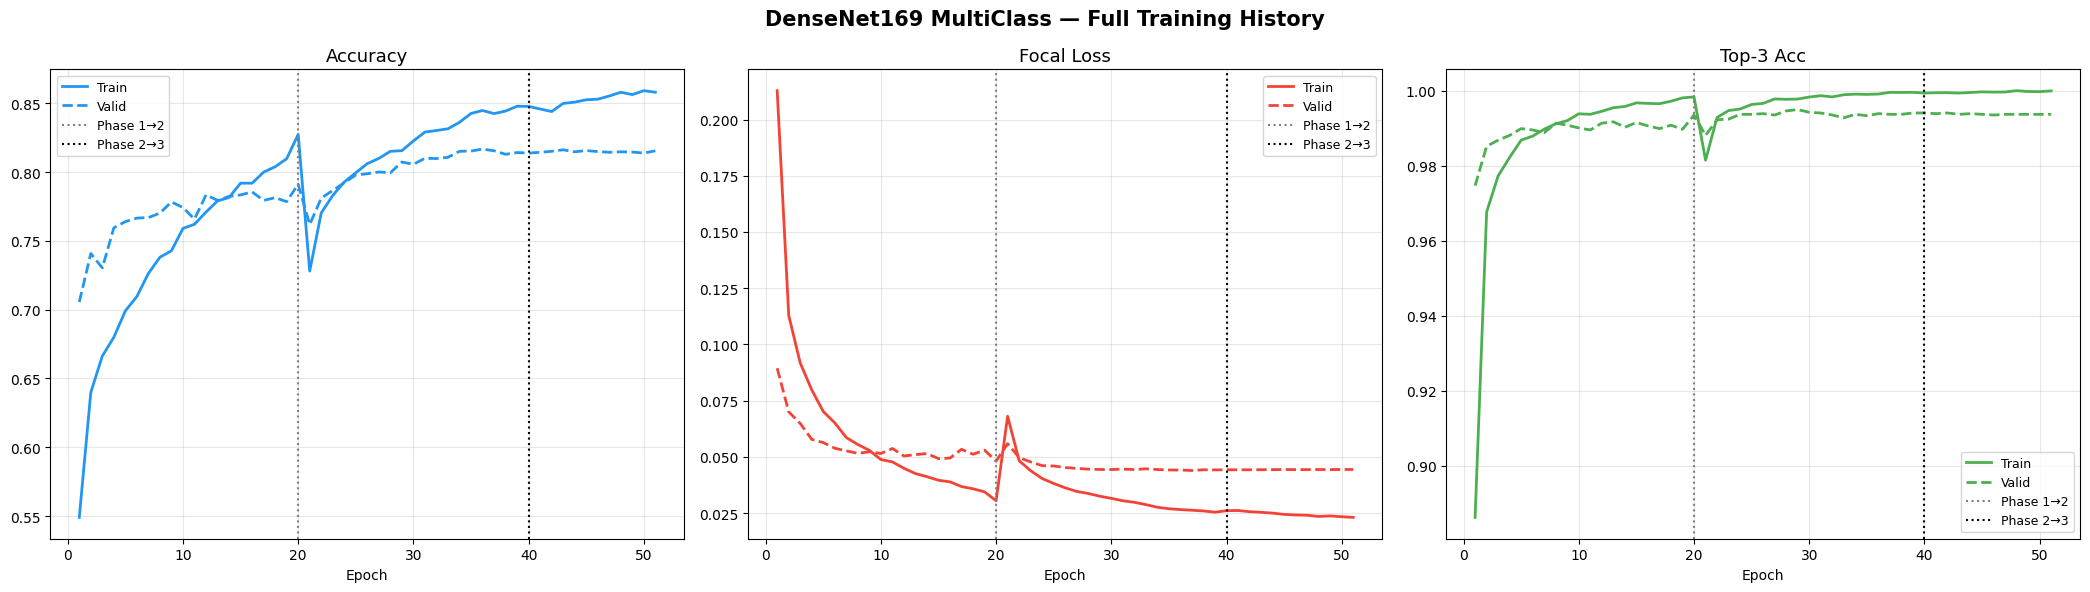

✅ Training curves saved


In [14]:
def merge_histories(*hists):
    merged = {}
    for key in hists[0].history:
        merged[key] = []
        for h in hists:
            if key in h.history:
                merged[key] += h.history[key]
    return merged

all_hist = merge_histories(history_p1, history_p2, history_p3)
p1_end   = len(history_p1.history['loss'])
p2_end   = p1_end + len(history_p2.history['loss'])

fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle('DenseNet169 MultiClass — Full Training History', fontsize=15, fontweight='bold')

metrics_to_plot = [
    ('categorical_accuracy', 'val_categorical_accuracy', 'Accuracy',   '#2196F3'),
    ('loss',                 'val_loss',                 'Focal Loss', '#F44336'),
    ('top3_accuracy',        'val_top3_accuracy',        'Top-3 Acc',  '#4CAF50'),
]

for ax, (tr_m, val_m, title, color) in zip(axes, metrics_to_plot):
    epochs = range(1, len(all_hist[tr_m])+1)
    ax.plot(epochs, all_hist[tr_m],  color=color, lw=2,   ls='-',  label='Train')
    ax.plot(epochs, all_hist[val_m], color=color, lw=2,   ls='--', label='Valid')
    ax.axvline(p1_end, color='gray',  ls=':', lw=1.5, label='Phase 1→2')
    ax.axvline(p2_end, color='black', ls=':', lw=1.5, label='Phase 2→3')
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Epoch')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUT_PATH}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Training curves saved')

## 🎯 Block 11 — Test Predictions

In [15]:
print('🔮 Loading best model and predicting...')

# Load best saved model
for phase in ['p3', 'p2', 'p1']:
    path = f'{OUT_PATH}/densenet_{phase}_best.keras'
    if os.path.exists(path):
        model = load_model(path, custom_objects={
            'categorical_focal_loss': categorical_focal_loss(),
            'loss_fn': categorical_focal_loss()
        })
        print(f'✅ Loaded best model from Phase {phase[-1]}')
        break

test_ds  = make_dataset(test_df,  augment=False, shuffle=False)
valid_ds = make_dataset(valid_df, augment=False, shuffle=False)

# Predictions (probabilities)
test_probs  = model.predict(test_ds,  verbose=1)   # shape: (N, 14)
valid_probs = model.predict(valid_ds, verbose=0)

# Predicted class (argmax)
test_preds  = np.argmax(test_probs,  axis=1)
valid_preds = np.argmax(valid_probs, axis=1)

# True labels
test_true  = test_df['label'].values[:len(test_preds)]
valid_true = valid_df['label'].values[:len(valid_preds)]

test_acc  = accuracy_score(test_true, test_preds)
valid_acc = accuracy_score(valid_true, valid_preds)

print(f'\n📊 Results:')
print(f'   Valid Accuracy : {valid_acc*100:.2f}%')
print(f'   Test  Accuracy : {test_acc*100:.2f}%')

🔮 Loading best model and predicting...
✅ Loaded best model from Phase 3
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

2026-02-22 02:52:25.485449: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-22 02:52:25.723292: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-22 02:52:26.219920: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-22 02:52:26.461112: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 361ms/step

📊 Results:
   Valid Accuracy : 81.62%
   Test  Accuracy : 78.26%


## 📊 Block 12 — Full Evaluation

In [16]:
# ── Core Metrics ──────────────────────────────────────────
acc    = accuracy_score(test_true, test_preds)
kappa  = cohen_kappa_score(test_true, test_preds)
f1_mac = f1_score(test_true, test_preds, average='macro',    zero_division=0)
f1_wtd = f1_score(test_true, test_preds, average='weighted', zero_division=0)
prec   = precision_score(test_true, test_preds, average='weighted', zero_division=0)
rec    = recall_score(test_true, test_preds, average='weighted',    zero_division=0)

# Top-3 accuracy
top3 = np.mean([
    test_true[i] in np.argsort(test_probs[i])[-3:]
    for i in range(len(test_true))
])

print('='*60)
print('  🏆  FINAL RESULTS — DenseNet169 MultiClass (14 Classes)')
print('='*60)
print(f'  Accuracy (Top-1)  : {acc*100:.2f}%')
print(f'  Accuracy (Top-3)  : {top3*100:.2f}%')
print(f'  Cohen Kappa       : {kappa:.4f}')
print(f'  F1 (Macro)        : {f1_mac:.4f}')
print(f'  F1 (Weighted)     : {f1_wtd:.4f}')
print(f'  Precision (Wtd)   : {prec:.4f}')
print(f'  Recall    (Wtd)   : {rec:.4f}')
print('='*60)
print()
print('📋 Classification Report (per class):')
print(classification_report(
    test_true, test_preds,
    target_names=CLASS_NAMES,
    digits=3, zero_division=0
))

  🏆  FINAL RESULTS — DenseNet169 MultiClass (14 Classes)
  Accuracy (Top-1)  : 78.26%
  Accuracy (Top-3)  : 98.65%
  Cohen Kappa       : 0.7641
  F1 (Macro)        : 0.7744
  F1 (Weighted)     : 0.7791
  Precision (Wtd)   : 0.7912
  Recall    (Wtd)   : 0.7826

📋 Classification Report (per class):
                   precision    recall  f1-score   support

     ELBOW_Normal      0.739     0.928     0.823       235
   ELBOW_Abnormal      0.837     0.739     0.785       230
    FINGER_Normal      0.698     0.841     0.763       214
  FINGER_Abnormal      0.870     0.680     0.764       247
   FOREARM_Normal      0.753     0.833     0.791       150
 FOREARM_Abnormal      0.853     0.576     0.688       151
      HAND_Normal      0.726     0.937     0.818       271
    HAND_Abnormal      0.839     0.524     0.645       189
   HUMERUS_Normal      0.857     0.770     0.811       148
 HUMERUS_Abnormal      0.824     0.800     0.812       140
  SHOULDER_Normal      0.775     0.761     0.768    

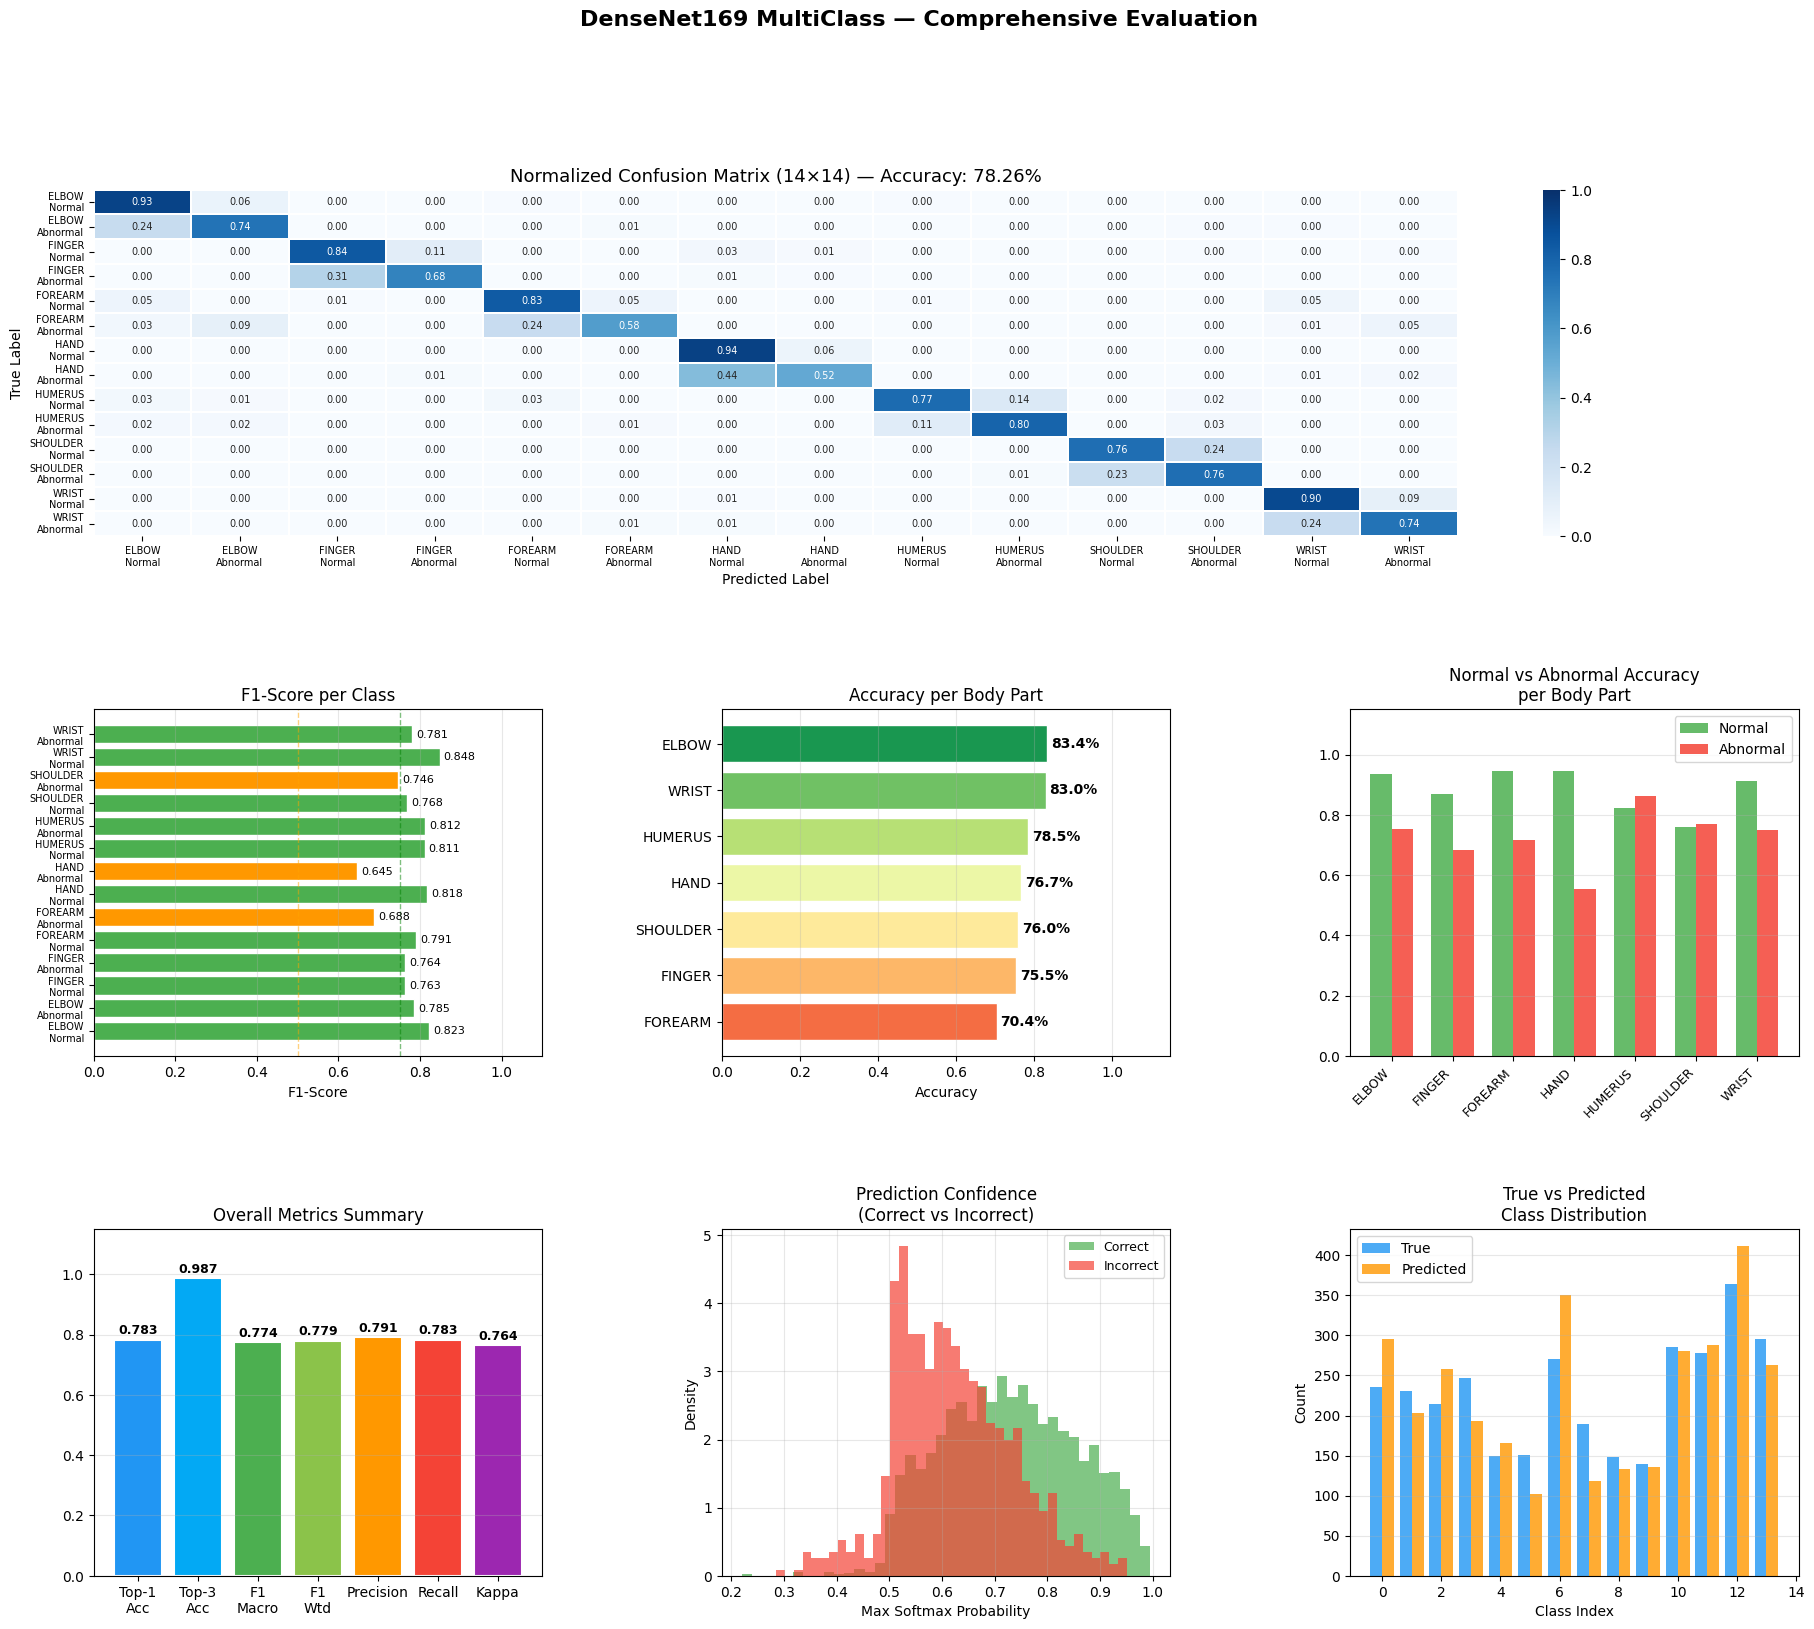

✅ Evaluation plots saved


In [17]:
# ── Comprehensive Visualization ───────────────────────────
fig = plt.figure(figsize=(22, 18))
gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.4)
fig.suptitle('DenseNet169 MultiClass — Comprehensive Evaluation', fontsize=16, fontweight='bold')

# ── 1: Confusion Matrix (14×14) ──
ax1 = fig.add_subplot(gs[0, :])
cm  = confusion_matrix(test_true, test_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(
    cm_norm, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=[c.replace('_',"\n") for c in CLASS_NAMES],
    yticklabels=[c.replace('_',"\n") for c in CLASS_NAMES],
    ax=ax1, linewidths=0.3, annot_kws={'size': 7},
    vmin=0, vmax=1
)
ax1.set_title(f'Normalized Confusion Matrix (14×14) — Accuracy: {acc*100:.2f}%', fontsize=13)
ax1.set_ylabel('True Label', fontsize=10)
ax1.set_xlabel('Predicted Label', fontsize=10)
ax1.tick_params(axis='both', labelsize=7)

# ── 2: Per-Class F1 ──
ax2 = fig.add_subplot(gs[1, 0])
f1_per_class = f1_score(test_true, test_preds, average=None, zero_division=0)
colors_f1 = ['#4CAF50' if f > 0.75 else '#FF9800' if f > 0.5 else '#F44336' for f in f1_per_class]
bars2 = ax2.barh([c.replace('_','\n') for c in CLASS_NAMES], f1_per_class,
                  color=colors_f1, edgecolor='white')
ax2.set_title('F1-Score per Class', fontsize=12)
ax2.set_xlabel('F1-Score')
ax2.set_xlim(0, 1.1)
ax2.axvline(x=0.75, color='green',  ls='--', lw=1, alpha=0.5)
ax2.axvline(x=0.50, color='orange', ls='--', lw=1, alpha=0.5)
for bar, val in zip(bars2, f1_per_class):
    ax2.text(bar.get_width()+0.01, bar.get_y()+bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=8)
ax2.grid(True, alpha=0.3, axis='x')
ax2.tick_params(axis='y', labelsize=7)

# ── 3: Per Body Part Accuracy ──
ax3 = fig.add_subplot(gs[1, 1])
test_copy = test_df.copy().iloc[:len(test_preds)].reset_index(drop=True)
test_copy['pred_label'] = test_preds
test_copy['correct']    = (test_copy['pred_label'] == test_copy['label']).astype(int)
bp_acc = test_copy.groupby('body_part')['correct'].mean().sort_values()
colors_bp2 = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(bp_acc)))
bp_bars = ax3.barh(bp_acc.index, bp_acc.values, color=colors_bp2, edgecolor='white')
ax3.set_title('Accuracy per Body Part', fontsize=12)
ax3.set_xlabel('Accuracy')
ax3.set_xlim(0, 1.15)
for bar, val in zip(bp_bars, bp_acc.values):
    ax3.text(bar.get_width()+0.01, bar.get_y()+bar.get_height()/2,
             f'{val*100:.1f}%', va='center', fontsize=10, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# ── 4: Normal vs Abnormal Accuracy per Body Part ──
ax4 = fig.add_subplot(gs[1, 2])
test_copy['pred_binary'] = test_copy['pred_label'].apply(lambda x: CLASS_NAMES[x].split('_')[1])
bp_binary_acc = test_copy.groupby(['body_part','binary']).apply(
    lambda g: (g['pred_binary'] == g['binary']).mean()
).unstack()
if 'Normal' in bp_binary_acc.columns and 'Abnormal' in bp_binary_acc.columns:
    x = np.arange(len(bp_binary_acc))
    w = 0.35
    ax4.bar(x - w/2, bp_binary_acc['Normal'],   w, label='Normal',   color='#4CAF50', alpha=0.85)
    ax4.bar(x + w/2, bp_binary_acc['Abnormal'], w, label='Abnormal', color='#F44336', alpha=0.85)
    ax4.set_xticks(x)
    ax4.set_xticklabels(bp_binary_acc.index, rotation=45, ha='right', fontsize=9)
    ax4.set_title('Normal vs Abnormal Accuracy\nper Body Part', fontsize=12)
    ax4.set_ylim(0, 1.15)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

# ── 5: Overall Metrics Summary ──
ax5 = fig.add_subplot(gs[2, 0])
metric_names  = ['Top-1\nAcc', 'Top-3\nAcc', 'F1\nMacro', 'F1\nWtd', 'Precision', 'Recall', 'Kappa']
metric_values = [acc, top3, f1_mac, f1_wtd, prec, rec, kappa]
colors_m = ['#2196F3','#03A9F4','#4CAF50','#8BC34A','#FF9800','#F44336','#9C27B0']
bars5 = ax5.bar(metric_names, metric_values, color=colors_m, edgecolor='white', linewidth=1.5)
ax5.set_ylim(0, 1.15)
ax5.set_title('Overall Metrics Summary', fontsize=12)
for bar, val in zip(bars5, metric_values):
    ax5.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02,
             f'{val:.3f}', ha='center', fontsize=9, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# ── 6: Prediction Confidence Distribution ──
ax6 = fig.add_subplot(gs[2, 1])
max_probs   = np.max(test_probs, axis=1)
correct_idx = test_preds == test_true
ax6.hist(max_probs[correct_idx],  bins=40, alpha=0.7, color='#4CAF50', label='Correct',   density=True)
ax6.hist(max_probs[~correct_idx], bins=40, alpha=0.7, color='#F44336', label='Incorrect', density=True)
ax6.set_title('Prediction Confidence\n(Correct vs Incorrect)', fontsize=12)
ax6.set_xlabel('Max Softmax Probability')
ax6.set_ylabel('Density')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# ── 7: Class Distribution Test vs Predictions ──
ax7 = fig.add_subplot(gs[2, 2])
true_counts = pd.Series(test_true).value_counts().sort_index()
pred_counts = pd.Series(test_preds).value_counts().sort_index().reindex(true_counts.index, fill_value=0)
x = np.arange(NUM_CLASSES)
w = 0.4
ax7.bar(x - w/2, true_counts.values, w, label='True',      color='#2196F3', alpha=0.8)
ax7.bar(x + w/2, pred_counts.values, w, label='Predicted', color='#FF9800', alpha=0.8)
ax7.set_title('True vs Predicted\nClass Distribution', fontsize=12)
ax7.set_xlabel('Class Index')
ax7.set_ylabel('Count')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

plt.savefig(f'{OUT_PATH}/evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Evaluation plots saved')

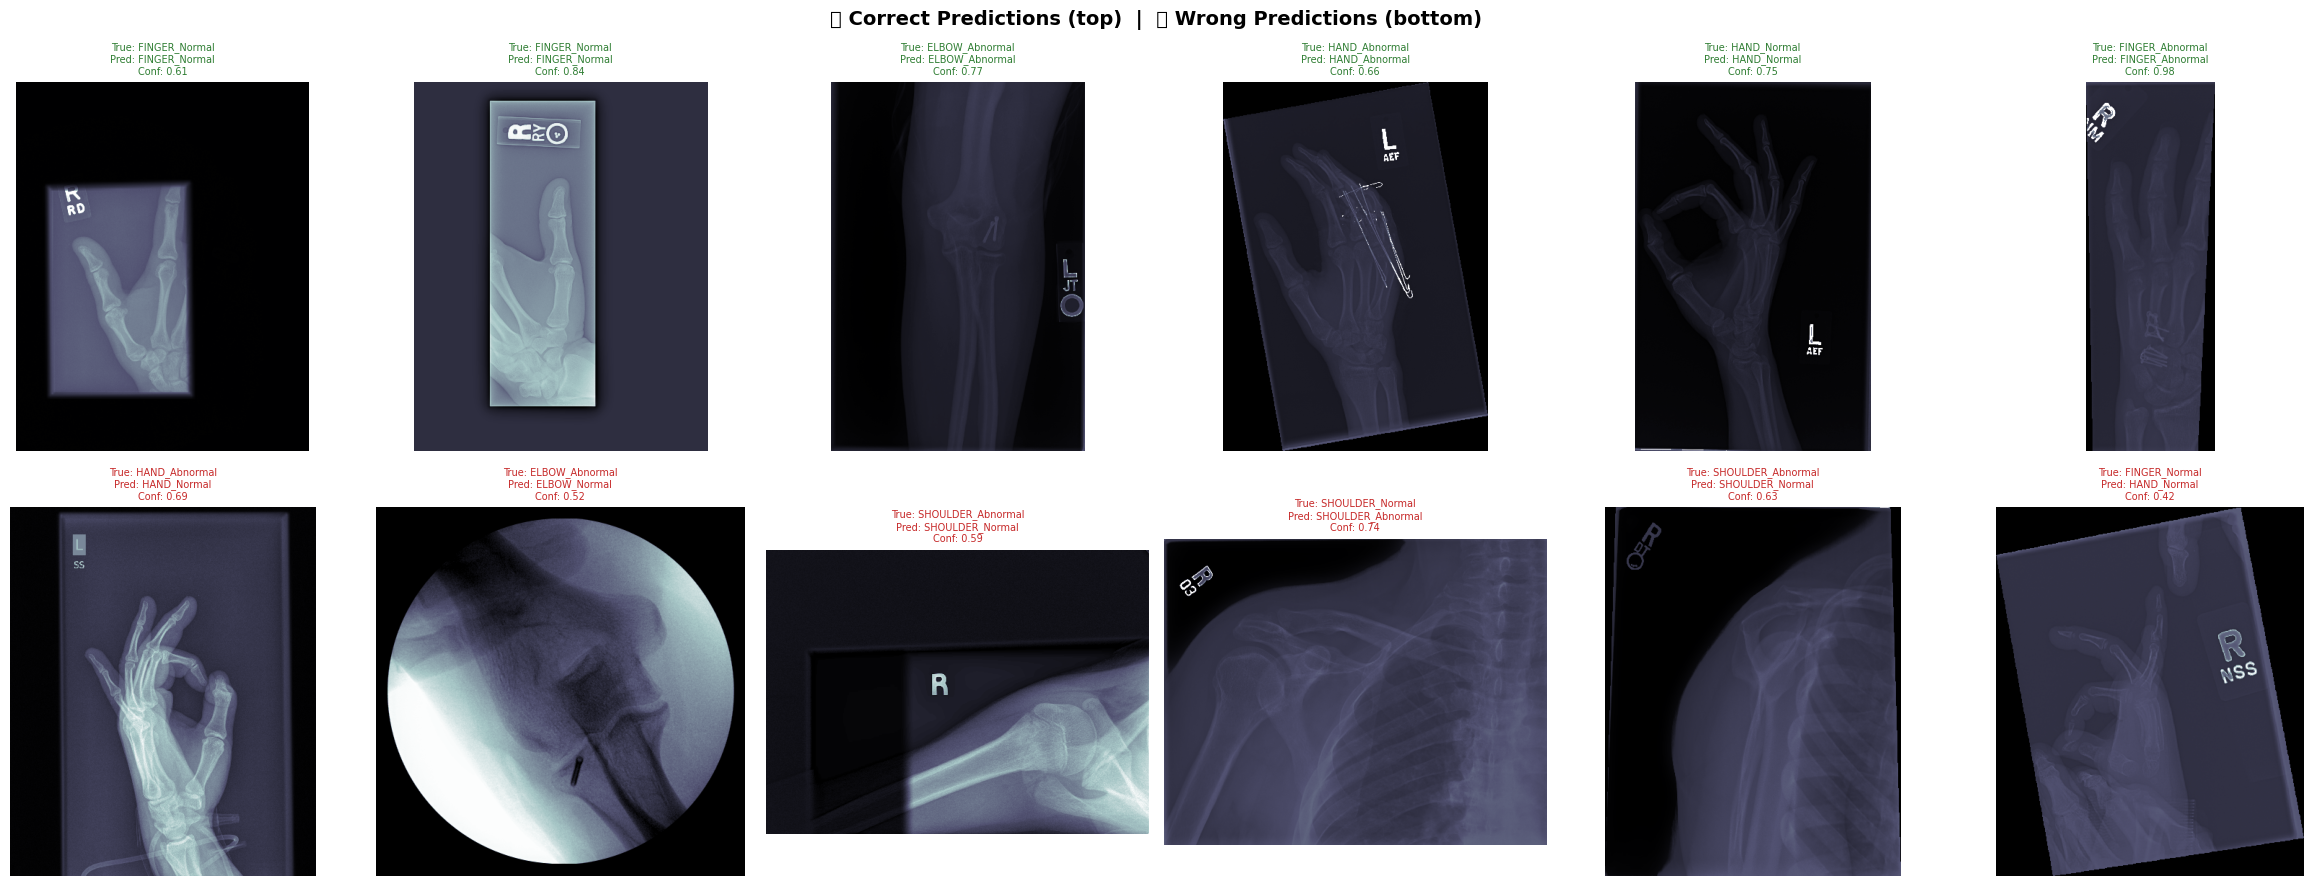

In [18]:
# ── Sample Correct vs Wrong Predictions ──────────────────
test_copy['pred_class_name'] = test_copy['pred_label'].apply(lambda x: CLASS_NAMES[x])
test_copy['true_class_name'] = test_copy['label'].apply(lambda x: CLASS_NAMES[x])
test_copy['confidence']      = np.max(test_probs[:len(test_copy)], axis=1)

correct_df = test_copy[test_copy['correct']==1].sample(min(6, test_copy['correct'].sum()), random_state=SEED)
wrong_df   = test_copy[test_copy['correct']==0].sample(min(6, (test_copy['correct']==0).sum()), random_state=SEED)

fig, axes = plt.subplots(2, 6, figsize=(24, 9))
fig.suptitle('✅ Correct Predictions (top)  |  ❌ Wrong Predictions (bottom)', fontsize=14, fontweight='bold')

for col, (_, row) in enumerate(correct_df.iterrows()):
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    axes[0,col].imshow(img, cmap='bone')
    axes[0,col].set_title(
        f"True: {row['true_class_name']}\nPred: {row['pred_class_name']}\nConf: {row['confidence']:.2f}",
        fontsize=7, color='#2E7D32'
    )
    axes[0,col].axis('off')

for col, (_, row) in enumerate(wrong_df.iterrows()):
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    axes[1,col].imshow(img, cmap='bone')
    axes[1,col].set_title(
        f"True: {row['true_class_name']}\nPred: {row['pred_class_name']}\nConf: {row['confidence']:.2f}",
        fontsize=7, color='#C62828'
    )
    axes[1,col].axis('off')

plt.tight_layout()
plt.savefig(f'{OUT_PATH}/correct_vs_wrong.png', dpi=150, bbox_inches='tight')
plt.show()

## 💾 Block 13 — Save Model & Results

In [19]:
print('💾 Saving...')

# Save final model
model.save(f'{OUT_PATH}/densenet169_multiclass_final.keras')

# Save predictions CSV
results_df = pd.DataFrame({
    'image_path'      : test_df['image_path'].values[:len(test_preds)],
    'body_part'       : test_df['body_part'].values[:len(test_preds)],
    'true_class'      : [CLASS_NAMES[i] for i in test_true],
    'pred_class'      : [CLASS_NAMES[i] for i in test_preds],
    'true_label'      : test_true,
    'pred_label'      : test_preds,
    'confidence'      : np.max(test_probs[:len(test_preds)], axis=1),
    'correct'         : (test_preds == test_true).astype(int)
})
results_df.to_csv(f'{OUT_PATH}/test_predictions.csv', index=False)

# Save arrays
np.save(f'{OUT_PATH}/test_probs.npy',  test_probs)
np.save(f'{OUT_PATH}/test_preds.npy',  test_preds)
np.save(f'{OUT_PATH}/true_labels.npy', test_true)

# Zip للتنزيل
import shutil
import os

files_to_zip = [
    'densenet169_multiclass_final.keras',
    'test_predictions.csv',
    'evaluation_results.png',
    'training_curves.png',
    'correct_vs_wrong.png',
    'eda_overview.png',
    'sample_images.png',
    'test_probs.npy',
    'test_preds.npy',
    'true_labels.npy',
]

os.makedirs(f'{OUT_PATH}/to_zip', exist_ok=True)
for f in files_to_zip:
    src = f'{OUT_PATH}/{f}'
    if os.path.exists(src):
        shutil.copy(src, f'{OUT_PATH}/to_zip/{f}')

shutil.make_archive(f'{OUT_PATH}/mura_multiclass_results', 'zip', f'{OUT_PATH}/to_zip')

print('✅ Model  → densenet169_multiclass_final.keras')
print('✅ CSV    → test_predictions.csv')
print('✅ ZIP    → mura_multiclass_results.zip')
zip_size = os.path.getsize(f'{OUT_PATH}/mura_multiclass_results.zip') / 1e6
print(f'   ZIP size: {zip_size:.1f} MB')

💾 Saving...
✅ Model  → densenet169_multiclass_final.keras
✅ CSV    → test_predictions.csv
✅ ZIP    → mura_multiclass_results.zip
   ZIP size: 142.9 MB


## 🏆 Block 14 — Final Summary

In [20]:
print('='*60)
print('  🏆  FINAL SUMMARY')
print('='*60)
print(f'  Dataset          : MURA v1.1 (Stanford)')
print(f'  Task             : Multi-Class (14 classes)')
print(f'  Model            : DenseNet169')
print(f'  Image Size       : {IM_SIZE}×{IM_SIZE}')
print(f'  Training Phases  : 3 (Transfer → Fine-Tune → Deep Fine-Tune)')
print(f'  Test Images      : {len(test_true):,}')
print('='*60)
print(f'  ✅ Top-1 Accuracy : {acc*100:.2f}%')
print(f'  ✅ Top-3 Accuracy : {top3*100:.2f}%')
print(f'  ✅ Cohen Kappa    : {kappa:.4f}')
print(f'  ✅ F1 (Macro)     : {f1_mac:.4f}')
print(f'  ✅ F1 (Weighted)  : {f1_wtd:.4f}')
print(f'  ✅ Precision      : {prec:.4f}')
print(f'  ✅ Recall         : {rec:.4f}')
print('='*60)
print()
print('📊 Accuracy per Body Part:')
bp_summary = test_copy.groupby('body_part')['correct'].agg(['mean','count'])
for bp, row in bp_summary.sort_values('mean', ascending=False).iterrows():
    bar = '█' * int(row['mean']*20)
    print(f'  {bp:<12} {row["mean"]*100:5.1f}%  {bar}  (n={int(row["count"])})')

print()
print('📊 Top-3 Confused Classes:')
cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
np.fill_diagonal(cm_df.values, 0)
for _ in range(3):
    idx = np.unravel_index(cm_df.values.argmax(), cm_df.shape)
    print(f'  {CLASS_NAMES[idx[0]]:22} → {CLASS_NAMES[idx[1]]:22} ({cm_df.values[idx]} times)')
    cm_df.values[idx] = 0

print()
print('✅ Project Complete!')

  🏆  FINAL SUMMARY
  Dataset          : MURA v1.1 (Stanford)
  Task             : Multi-Class (14 classes)
  Model            : DenseNet169
  Image Size       : 320×320
  Training Phases  : 3 (Transfer → Fine-Tune → Deep Fine-Tune)
  Test Images      : 3,197
  ✅ Top-1 Accuracy : 78.26%
  ✅ Top-3 Accuracy : 98.65%
  ✅ Cohen Kappa    : 0.7641
  ✅ F1 (Macro)     : 0.7744
  ✅ F1 (Weighted)  : 0.7791
  ✅ Precision      : 0.7912
  ✅ Recall         : 0.7826

📊 Accuracy per Body Part:
  ELBOW         83.4%  ████████████████  (n=465)
  WRIST         83.0%  ████████████████  (n=659)
  HUMERUS       78.5%  ███████████████  (n=288)
  HAND          76.7%  ███████████████  (n=460)
  SHOULDER      76.0%  ███████████████  (n=563)
  FINGER        75.5%  ███████████████  (n=461)
  FOREARM       70.4%  ██████████████  (n=301)

📊 Top-3 Confused Classes:
  HAND_Abnormal          → HAND_Normal            (83 times)
  FINGER_Abnormal        → FINGER_Normal          (76 times)
  WRIST_Abnormal         → WRIST

In [22]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K

# ── Define Custom Loss (نفس اللي اتستخدم في التدريب) ─────
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss

# ── Load Model ───────────────────────────────────────────
model = tf.keras.models.load_model(
    f'{OUT_PATH}/densenet169_multiclass_final.keras',
    custom_objects={'categorical_focal_loss': categorical_focal_loss}
)

# ── Inference Function ───────────────────────────────────
def predict_xray(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IM_SIZE, IM_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    probs = model.predict(img, verbose=0)[0]
    pred_idx = np.argmax(probs)
    pred_class = CLASS_NAMES[pred_idx]
    confidence = probs[pred_idx] * 100

    body_part, status = pred_class.split('_')
    emoji = '🔴 كسر / تشوه' if status == 'Abnormal' else '🟢 طبيعي'

    print(f'🦴 العضو     : {body_part}')
    print(f'📋 التشخيص  : {emoji}')
    print(f'🎯 الثقة    : {confidence:.1f}%')
    print(f'\n📊 Top-3:')
    top3 = np.argsort(probs)[::-1][:3]
    for i in top3:
        print(f'   {CLASS_NAMES[i]:<25} {probs[i]*100:.1f}%')

# ── Test على صورة من الـ dataset ─────────────────────────
sample = test_df.sample(1).iloc[0]
print(f'📁 الصورة: {sample["image_path"]}')
print(f'✅ التشخيص الحقيقي: {sample["class_name"]}\n')
predict_xray(sample['image_path'])

📁 الصورة: /kaggle/input/datasets/cjinny/mura-v11/MURA-v1.1/valid/XR_HAND/patient11593/study1_negative/image1.png
✅ التشخيص الحقيقي: HAND_Normal

🦴 العضو     : HAND
📋 التشخيص  : 🟢 طبيعي
🎯 الثقة    : 64.1%

📊 Top-3:
   HAND_Normal               64.1%
   HAND_Abnormal             35.6%
   FINGER_Normal             0.2%
